In [1]:
using LinearAlgebra
using DifferentialEquations
using Plots; pyplot()
using StatPlots
using StatsBase
using NLsolve
using LaTeXStrings

upscale = 8 #8x upscaling in resolution
fig_width = 800
#fntsm = Plots.font("sans-serif", 10.0*upscale)
#fntlg = Plots.font("sans-serif", 14.0*upscale)
#default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
default(dpi=300) #Only for PyPlot - presently broken


$$
    \dot{x} = \sigma x - \alpha x^3 + \sqrt{2\gamma}\eta
$$

In [2]:
function Fokker_Planck(dP, P, params, t)
    # --> Get parameters.
    nx = length(P)
    x, σ, α, ϵ, γ = params
    Δx = x[2] - x[1]
    
    for i = 2:nx-1
        # --> Compute laplacian.
        if (i>2) & (i<nx-2)
            ΔP = -1.0/12.0*P[i-2] + 4.0/3.0*P[i-1] - 5.0/2.0*P[i] + 4.0/3.0*P[i+1] - 1.0/12.0*P[i+2]
        else
            ΔP = P[i-1] - 2*P[i] + P[i+1]
        end
        ΔP /= (Δx)^2
        
        # --> Compute vector field.
        ẋ = σ*x[i] - α*x[i]^3 + ϵ
        div = σ - 3α*x[i]^2
        
        # --> Compute gradient
        if (i>3) & (i<nx-3)
            if ẋ>0
                dpdx = -2*P[i-3] + 15*P[i-2] - 60*P[i-1] + 20*P[i] + 30*P[i+1] - 3*P[i+2]
            else
                dpdx = 2*P[i+3] - 15*P[i+2] + 60*P[i+1] - 20*P[i] - 30*P[i-1] + 3*P[i-2]
            end
            dpdx /= 60*Δx
        else
            if ẋ<0
                dpdx = ( P[i+1] - P[i] ) / Δx
            else
                dpdx = ( P[i] - P[i-1] ) / Δx
            end
        end
        
        # --> Compute rhs.
        dP[i] = -div*P[i] - ẋ*dpdx + γ*ΔP
    end
    
    return dP
end

Fokker_Planck (generic function with 1 method)

In [3]:
nx = 513
xmin, xmax = -10.0, 10.0
Δx = (xmax - xmin) / (nx-1)
x = [xmin + (i-1)Δx for i = 1:nx];

σ, α, ϵ, γ = 0.1, 0.01, 0.0, 0.1
params = [x, σ, α, ϵ, γ];

In [4]:
P = zeros(nx)
dP = similar(P)
for i = 1:nx
    P[i] = exp( -(x[i]-1)^2/0.2 ) + exp( -(x[i]+1)^2/0.2 )
end

P /= sum(P)*Δx;

In [5]:
tspan = (0.0, 200.0)
prob = ODEProblem(Fokker_Planck, P, tspan, params)
sol = solve(prob, alg=SSPRK432());

In [6]:
f(x, p, t) = σ*x - α*x^3 + ϵ
g(x, p, t) = √(2γ)

tspan = (0.0, 1.5e6)
prob = SDEProblem(f, g, -1.0, tspan)
sde_sol = solve(prob, SRIW1(), dt=0.01);
sde_sol_bis = solve(prob, SRIW1(), dt=0.01);

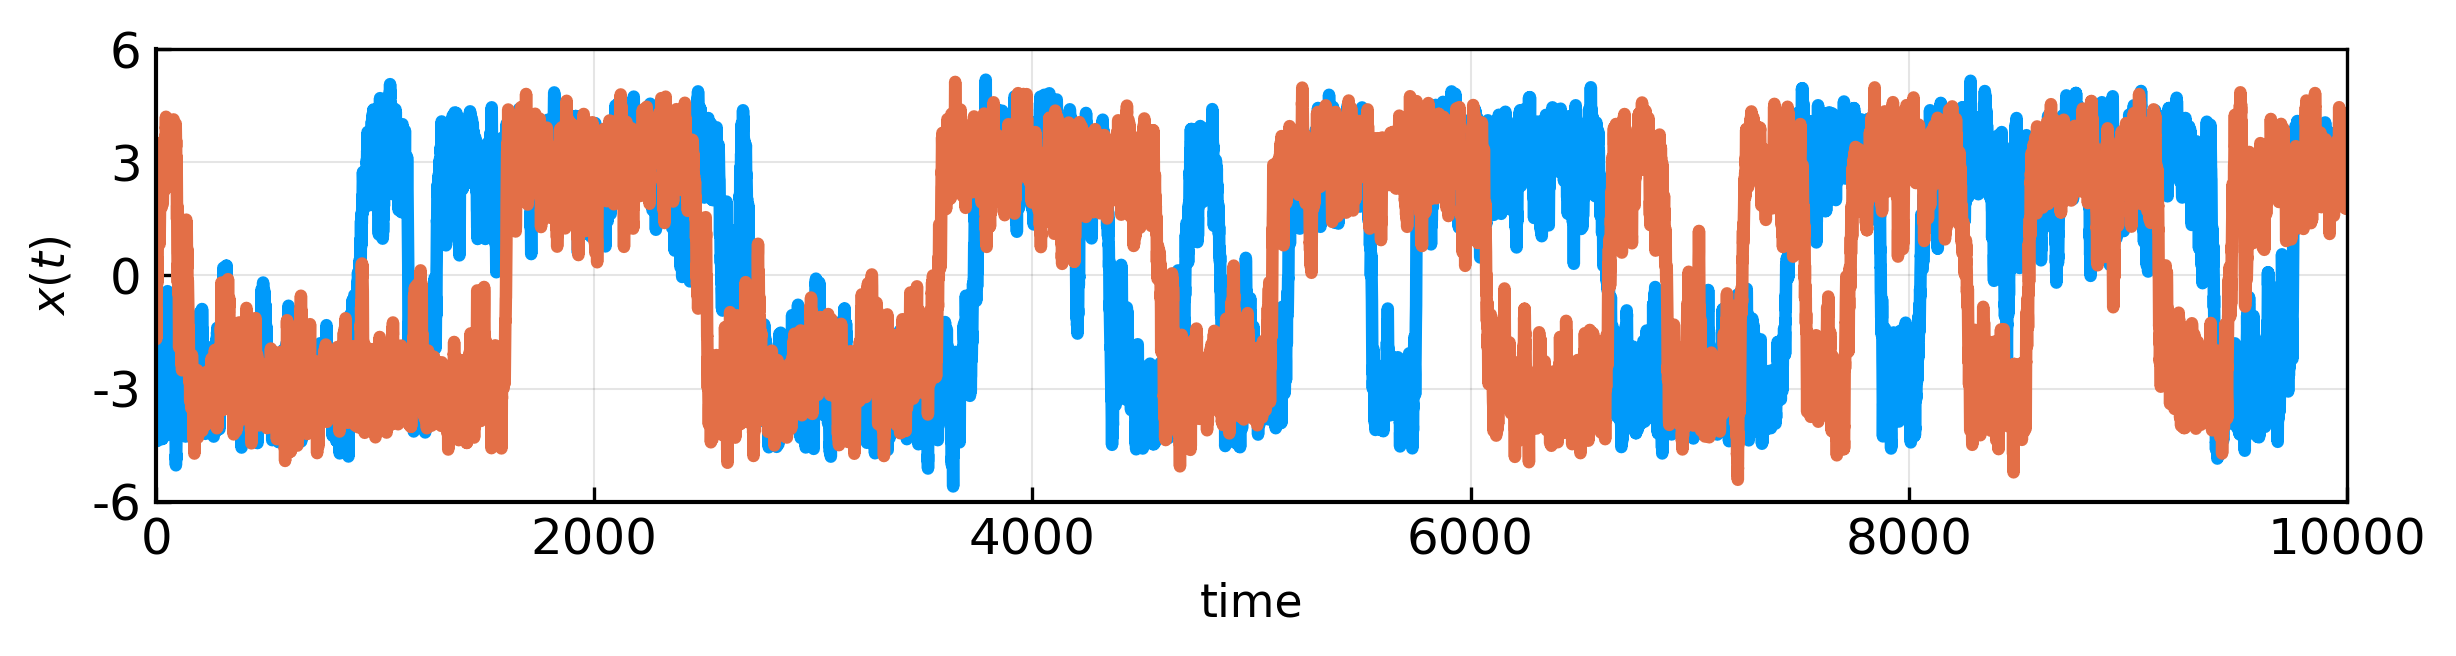

In [10]:
plot(
    sde_sol, vars=(0, 1),
    xlim = (0, 1e4), xlabel = "time", tickfont = 12,
    ylim = (-6, 6), yticks = -6:3:6, ylabel = L"$x(t)$",
    framestyle = :box,
    size = (fig_width, fig_width/4),
    legend = :none
    )

plot!(sde_sol_bis, vars=(0, 1),
    xlim = (0, 1e4), xlabel = "time", tickfont = 12,
    ylim = (-6, 6), yticks = -6:3:6, ylabel = L"$x(t)$",
    framestyle = :box,
    size = (fig_width, fig_width/4),
    legend = :none)

savefig("stochastic_pitchfork.pdf")

In [8]:
t = collect(tspan[1]:0.1:tspan[2])
z = sde_sol(t);
h = fit(Histogram, z, nbins=250)
h = normalize(h, mode=:pdf);

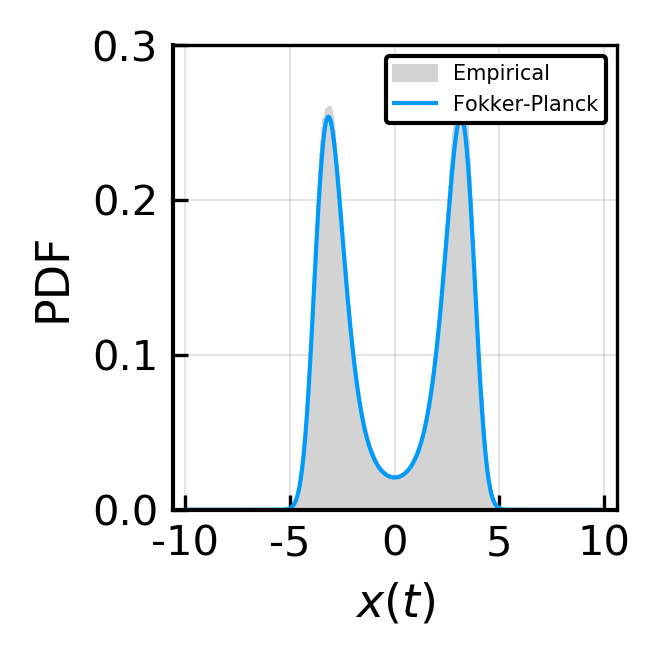

In [9]:
plot(
    h,
    ylim = (0, 0.3), yticks = 0:0.1:0.3, ylabel = "PDF", tickfont = 10,
    xlabel = L"$x(t)$",
    size = (fig_width/4, fig_width/4),
    framestyle = :box,
    color = :lightgray,
    linecolor = :match,
    linewidth = 1,
    label = "Empirical",
)

plot!(x, sol(200),
    color = 1,
    label = "Fokker-Planck",
    legendfontsize = 5,
    legend = :topright
)


savefig("stochastic_pitchfork_pdf.pdf")